<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter3DeepNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to work with image data


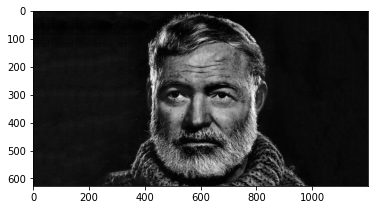

In [2]:
%matplotlib inline
import cv2, matplotlib.pyplot as plt
img = cv2.imread('img.jpg')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')


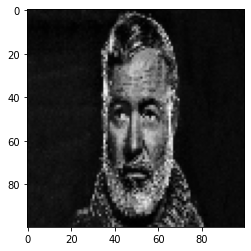

In [3]:
img_gray_smaller = cv2.resize(img_gray, (100,100))
plt.imshow(img_gray_smaller, cmap = 'gray')


Preparing the image data for image classification. We will be using the Fashion MNIST dataset. The overarching idea here is to use the feature that the neural network finds and to not extract those features manually.

In [2]:
from torchvision import datasets
import torchvision
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download = True, train = True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



Here we have to separate the images as training images and their labels as targets

In [3]:
tr_images = fmnist.data
tr_targets = fmnist.targets

Let's see how the tensors taht we've loaded actually look like

In [4]:
unique_values = tr_targets.unique()
print(f'Shape of training images {tr_images.shape}')
print(f'Shape of training labels {tr_targets.shape}')
print(f'Distinct class values {unique_values}')
print(f'Class semantics {fmnist.classes}')

Shape of training images torch.Size([60000, 28, 28])
Shape of training labels torch.Size([60000])
Distinct class values tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Class semantics ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Let's see the actual images we're dealing with

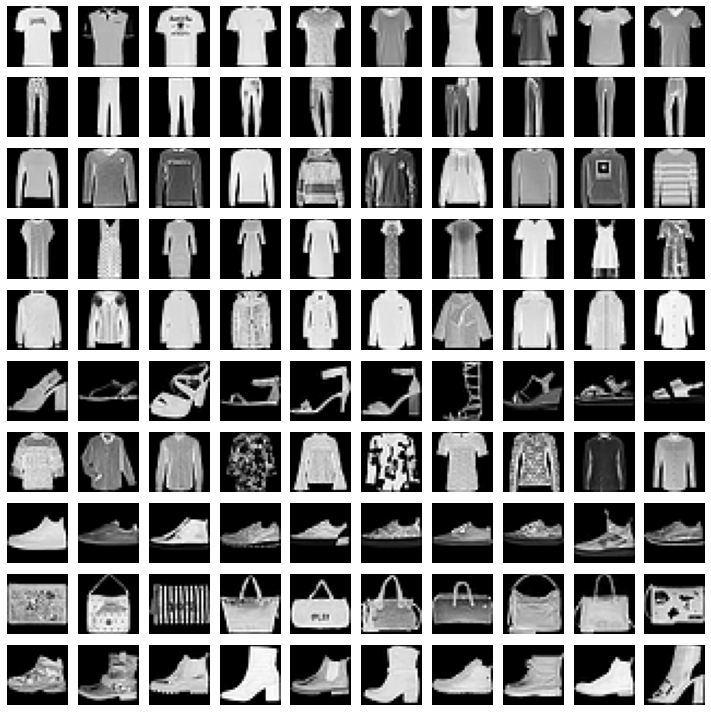

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

r, c = len(tr_targets.unique()), 10
fig, ax = plt.subplots(r, c, figsize = (10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0] #indices of rows coresponding to class label_class
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x,y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap = 'gray')
plt.tight_layout()

# Creating a Neural network

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()
    x = x.view(-1,28*28) #flatten the image
    self.x , self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)


Create a dataloader that will return 32 data points from our defined FashionMNIST dataset

In [8]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True )
  return trn_dl

Here we define a model and the loss function and the optimizer. We have one hidden layer of a 1000 neurons and we are using the Adam optimizer with the default values of b1, b2 are 0.9 and 0.999 without L2 regularization and the learning rate of 0.01 that is fixed i.e no decay

In [20]:
from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
          nn.Linear(28 * 28, 1000),
          nn.ReLU(),
          nn.Linear(1000,10)
      ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr = 1e-2)
  return model, loss_fn, optimizer

A function for training the neural network

In [21]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item() #get the scalar value of the loss for the current mini batch

Calculating accuracy for the given dataset

In [22]:
@torch.no_grad() #there is no updating here so with this decorator we are telling torch to not compute the gradients of tensors here
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1) #find the max values of each row of predictions
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()


Let's actually train the Neural network

In [23]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []  #it will contain the loss and accuracy of each batch within an epoch

for epoch in range(10):
  print(f'Epoch is {epoch}')
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch  #create a 32 values mini batch by iterating over the dataloader
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)  #store the loss value for the batch in batch_loss and add it to epoch losses
  epoch_loss = np.array(epoch_losses).mean() #the average loss over all batches within an epoch
  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies) #similarly, calculate accuracy per batch and find the average accuracy over all batches for the same epoch
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)


Epoch is 0
Epoch is 1
Epoch is 2
Epoch is 3
Epoch is 4
Epoch is 5
Epoch is 6
Epoch is 7
Epoch is 8
Epoch is 9


Let's plot the training loss and accuracy over epochs

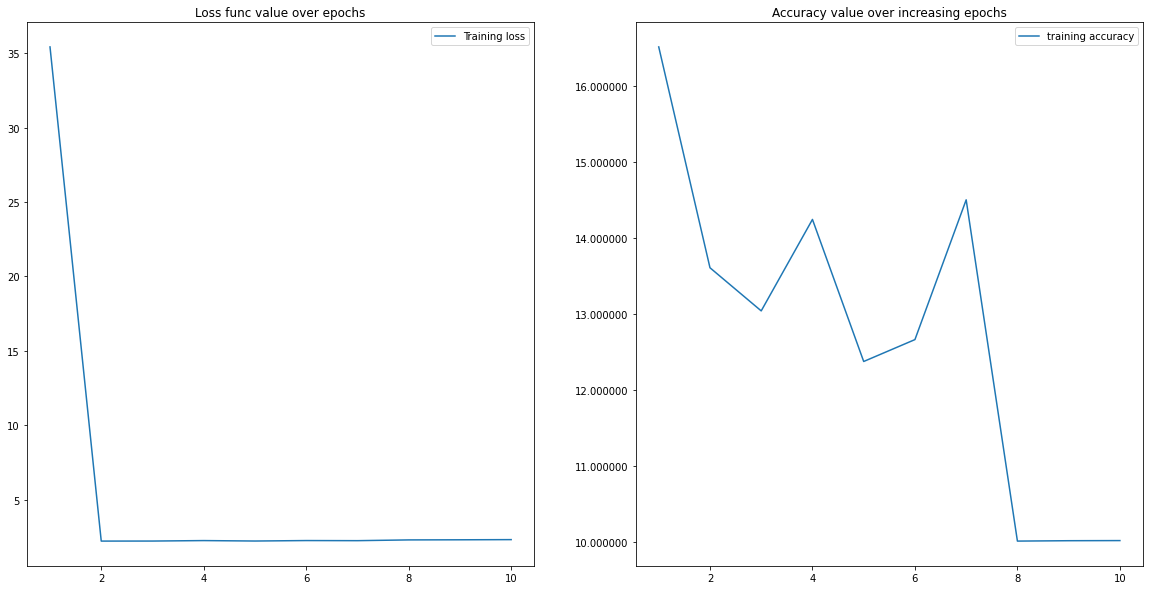

In [24]:
epochs = np.arange(10) + 1
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.title('Loss func value over epochs')
plt.plot(epochs, losses, label = 'Training loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label = 'training accuracy')
plt.gca().set_yticklabels(['{:0f}'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

Even though our loss function decreases quickly at first is doesn't further decrease as the epochs pass. Note that our accuracy drops sharply at around 12% and doesn't increase as the epochs pass. Meaning no mather for how long we train the NN, our model isn't going to improve its accuracy. 
This leads us to try to improve the hyperparameter values we have used as well as look into other optimization algorithms we could use.

We have used a rather naive approach to solve this problem. Now, we are going to utilize various the fine tuning of hyperparameters as well as overall good practices when dealing with NN training to achieve the best possible performance.

# Scaling the dataset to improve model accuracy